In [46]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis,get_time_plate_info_long_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
import scienceplots
import logging
logging.getLogger().setLevel(logging.WARNING)
%matplotlib widget
plt.style.use('presentation.mplstyle')
# plt.style.use('science')
plates = ['94_20201123']
plate_select = [94]
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure2\versionsFromCoco"
width = 1.6
height = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
folders,time_plate_info_long = get_time_plate_info_long_from_analysis(analysis_folders,use_saved=False)

time_plate_info["time_since_begin"] = time_plate_info["time_since_begin"]
# time_plate_info_long['timestep'] = time_plate_info_long.index

In [49]:
Css = {}
lambss = {}
dss = {}
meancurves = {}
meancurves2 = {}
t0ss = {}
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}

2023-03-21 11:02:33,645-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2023-03-21 11:02:34,840-[WARNING]- matplotlib.backends.backend_ps:296 -> The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


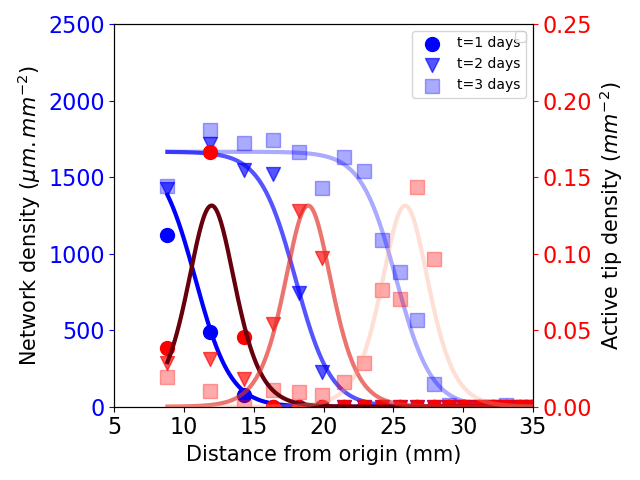

In [4]:
max_indexes = {plate : 20 for plate in plate_select}
cmap1 = mpl.cm.get_cmap("summer")
cmap2 = mpl.cm.get_cmap("Reds")
plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}
fig, ax = plt.subplots()
ax.axis([5,35,0,2500])
ax.set_xlabel('Distance from origin (mm)')
ax.set_ylabel('Network density ($\mu m.mm^{-2}$)') 
ax2=ax.twinx()
ax2.set_ylim((0,0.25))
ax2.set_ylabel('Active tip density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
timesteps = range(0,timestep[plate],timestep[plate]//4) 
timesteps = [25,50,75] 

lines = []
markers = ['o','v','s']
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    ax.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color="blue",label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days',
           alpha = (len(timesteps)-i)/len(timesteps),linewidth=1,marker = markers[i])
   
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    ax.plot(xs,wave(xt,*popt_f),alpha = (len(timesteps)-i)/len(timesteps),color='blue')
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    ax2.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = markers[i],color="red",
           alpha = (len(timesteps)-i)/len(timesteps))
    
    line = {"type" : "data tip density","x" : (np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))),"y" : yvalues,"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1))}
    lines.append(line)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    ax2.plot(xs,dwave(xt,*popt_f2),alpha = (len(timesteps)-i)/len(timesteps),color=cmap2((len(timesteps)-i)/len(timesteps)))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
#     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]*10, facecolor=cmap2((len(timesteps)-i)/len(timesteps)), edgecolor="black") for j,x in enumerate(xs)]

#     for ellipse in ellipses:
#         ax2.add_artist(ellipse)
    line = {"type" : "fit tip density","x" : xs,"y" : dwave(xt,*popt_f2),"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1)) }
    lines.append(line)
    right = 0.90
    top = 0.90
    fontsize = 10
ax.legend()
ax2.legend()
plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2Abis.svg'))
plt.savefig(os.path.join(path_figure,'Figure2Bbis.eps'))


2023-04-07 09:25:36,419-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


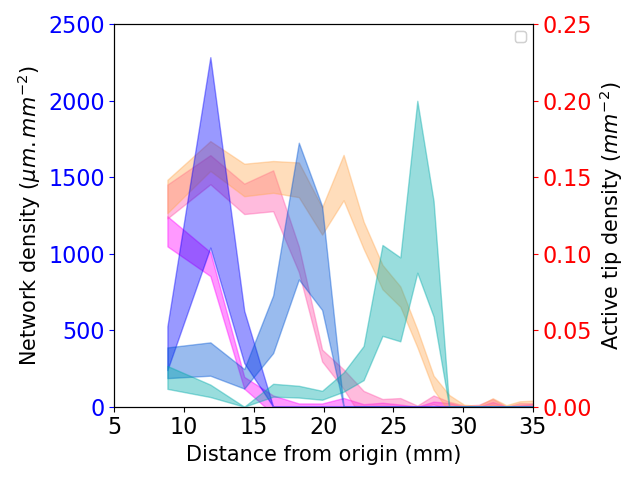

In [19]:
max_indexes = {plate : 20 for plate in plate_select}
cmap = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]

table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}
fig, ax = plt.subplots()
ax.axis([5,35,0,2500])
ax.set_xlabel('Distance from origin (mm)')
ax.set_ylabel('Network density ($\mu m.mm^{-2}$)') 
ax2=ax.twinx()
ax2.set_ylim((0,0.25))
ax2.set_ylabel('Active tip density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
timesteps = range(0,timestep[plate],timestep[plate]//4) 
timesteps = [25,50,75] 
lines_legends = []
labels = []
lines = []
markers = ['o','v','s']
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    # def density(x):
    #     area = x**2
    #     index = int(area//incr)
    #     column = f"ring_density_incr-100_index-{index}"
    #     return(float(table[column][t]))
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-new"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    errvalues = [err(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    # scat1 = ax.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i)/len(timesteps)),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days',linewidth=1)
    table = table.sort_values('area_sep_comp')
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    # print(err)
    # err = 0*ys + 80
    ax.fill_between(xs, ys-err, ys+err,color=cmap((i)/len(timesteps)),alpha = 0.4)
    # draw_error_band(ax, xs, ys,err,color=cmap((len(timesteps)-i)/len(timesteps)),alpha = 0.6)
    #     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]/2000, facecolor=cmap((len(timesteps)-i)/len(timesteps)), edgecolor="white") for j,x in enumerate(xs)]

#     for ellipse in ellipses:
#         ax.add_artist(ellipse)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    # ax.plot(xs,wave(xt,*popt_f),color=cmap((len(timesteps)-i)/len(timesteps)))
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    # scat2 = ax2.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap2((i)/len(timesteps)),
    #        alpha = (len(timesteps)-i)/len(timesteps))
    
    line = {"type" : "data tip density","x" : (np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))),"y" : yvalues,"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1))}
    lines.append(line)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    # ax2.plot(xs,dwave(xt,*popt_f2),color=cmap2((len(timesteps)-i)/len(timesteps)))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = np.std(ys)*abs(ys)/0.10
    # err = 0*ys + 80
    ax2.fill_between(xs, ys-err, ys+err,color=cmap2((i)/len(timesteps)),alpha = 0.4)
#     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]/0.10, facecolor=cmap2((len(timesteps)-i)/len(timesteps)), edgecolor="white") for j,x in enumerate(xs)]

#     for ellipse in ellipses:
#         ax2.add_artist(ellipse)
#     lines_legends.append((scat1, scat2))
#     labels.append(f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    

#     line = {"type" : "fit tip density","x" : xs,"y" : dwave(xt,*popt_f2),"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1)) }
#     lines.append(line)
    right = 0.90
    top = 0.90
    fontsize = 10
l = ax.legend(lines_legends,labels,
               handler_map={tuple: HandlerTuple(ndivide=None)})
# ax.legend()
ax2.legend()
plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2B.svg'))
# plt.savefig(os.path.join(path_figure,'Figure2B.eps'))


In [64]:
Cmean = 1421

2023-04-16 14:55:03,237-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


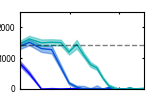

In [71]:
max_indexes = {plate : 20 for plate in plate_select}
cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")
# cmap = mpl.cm.get_cmap("Blues")
# cmap2 = mpl.cm.get_cmap("Reds")
plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]

table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}
f, ax  = plt.subplots(figsize=(width,height))

ax.axis([10,35,0,2500])
# ax2.set_xlabel('distance from origin, $r$ (mm)', wrap=True)
ax.set_ylabel('hyphae density \n($\mu m.mm^{-2}$)') 
# ax2.set_ylim((0,0.25))
# ax2.set_ylabel('tip density \n ($mm^{-2}$)')
# ax.tick_params(axis='y', colors='blue')
# ax2.tick_params(axis='y', colors='red')
timesteps = range(0,timestep[plate],timestep[plate]//4) 
timesteps = [25,50,75] 
lines_legends = []
labels = []
lines = []
markers = ['o','v','s']
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-new"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    errvalues = [err(x) for x in xvalues]
    
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i)/len(timesteps)),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    table = table.sort_values('area_sep_comp')
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    ax.fill_between(xs, ys-err, ys+err,color=cmap((i)/len(timesteps)),alpha = 0.4)

    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    errvalues = [err(x) for x in xvalues]
    
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    # scat2 = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap2((i)/len(timesteps)))
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
ax.set_xticklabels([])
ax.hlines(Cmean,5,35,color='black',linestyle='--',alpha = 0.5)

    # ax2.fill_between(xs, ys-err, ys+err,color=cmap2((i)/len(timesteps)),alpha = 0.4)
plt.savefig(os.path.join(path_figure,'Figure2B1.pdf'), transparent=True, bbox_inches='tight')



2023-04-16 14:55:26,670-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


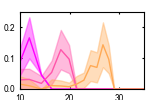

In [72]:
max_indexes = {plate : 20 for plate in plate_select}
cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")
# cmap = mpl.cm.get_cmap("Blues")
# cmap2 = mpl.cm.get_cmap("Reds")
plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]

table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}
f, ax2  = plt.subplots(figsize=(width,height))

# ax.axis([5,35,0,2500])
ax2.set_xlabel('distance from origin, $r$ (mm)', wrap=True)
# ax.set_ylabel('hyphae density \n($\mu m.mm^{-2}$)') 
ax2.set_ylim((0,0.25))
ax2.set_xlim((10,35))

ax2.set_ylabel('tip density \n ($mm^{-2}$)')
# ax.tick_params(axis='y', colors='blue')
# ax2.tick_params(axis='y', colors='red')
timesteps = range(0,timestep[plate],timestep[plate]//4) 
timesteps = [25,50,75] 
lines_legends = []
labels = []
lines = []
markers = ['o','v','s']
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-new"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    errvalues = [err(x) for x in xvalues]
    
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    # scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i)/len(timesteps)),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    table = table.sort_values('area_sep_comp')
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    # ax.fill_between(xs, ys-err, ys+err,color=cmap((i)/len(timesteps)),alpha = 0.4)

    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    errvalues = [err(x) for x in xvalues]
    
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    scat2 = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap2((i)/len(timesteps)))
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    
    ax2.fill_between(xs, ys-err, ys+err,color=cmap2((i)/len(timesteps)),alpha = 0.4)
plt.savefig(os.path.join(path_figure,'Figure2B2.pdf'), transparent=True, bbox_inches='tight')



2023-04-12 09:16:05,800-[WARNING]- matplotlib.backends.backend_ps:296 -> The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-04-12 09:16:05,907-[INFO]- fontTools.subset:2815 -> maxp pruned
2023-04-12 09:16:05,911-[INFO]- fontTools.subset:2799 -> LTSH dropped
2023-04-12 09:16:05,916-[INFO]- fontTools.subset:2815 -> cmap pruned
2023-04-12 09:16:05,927-[INFO]- fontTools.subset:2799 -> kern dropped
2023-04-12 09:16:05,929-[INFO]- fontTools.subset:2815 -> post pruned
2023-04-12 09:16:05,933-[INFO]- fontTools.subset:2799 -> PCLT dropped
2023-04-12 09:16:05,993-[INFO]- fontTools.subset:2815 -> GPOS pruned
2023-04-12 09:16:06,020-[INFO]- fontTools.subset:2815 -> GSUB pruned
2023-04-12 09:16:06,022-[INFO]- fontTools.subset:2799 -> JSTF dropped
2023-04-12 09:16:06,026-[INFO]- fontTools.subset:2799 -> DSIG dropped
2023-04-12 09:16:06,029-[INFO]- fontTools.subset:2815 -> name pruned
2023-04-12 09:16:06,237-[INFO]- fontTools.subset:2815 

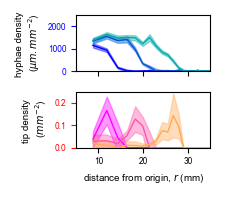

In [5]:
max_indexes = {plate : 20 for plate in plate_select}
cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")
# cmap = mpl.cm.get_cmap("Blues")
# cmap2 = mpl.cm.get_cmap("Reds")
plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]

table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}
f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(2.3,2))

ax.axis([5,35,0,2500])
ax2.set_xlabel('distance from origin, $r$ (mm)', wrap=True)
ax.set_ylabel('hyphae density \n($\mu m.mm^{-2}$)') 
ax2.set_ylim((0,0.25))
ax2.set_ylabel('tip density \n ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
timesteps = range(0,timestep[plate],timestep[plate]//4) 
timesteps = [25,50,75] 
lines_legends = []
labels = []
lines = []
markers = ['o','v','s']
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-new"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    errvalues = [err(x) for x in xvalues]
    
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i)/len(timesteps)),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    table = table.sort_values('area_sep_comp')
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    ax.fill_between(xs, ys-err, ys+err,color=cmap((i)/len(timesteps)),alpha = 0.4)

    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    errvalues = [err(x) for x in xvalues]
    
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    scat2 = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap2((i)/len(timesteps)))
    
    line = {"type" : "data tip density","x" : (np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))),"y" : yvalues,"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1))}
    lines.append(line)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    
    ax2.fill_between(xs, ys-err, ys+err,color=cmap2((i)/len(timesteps)),alpha = 0.4)
# ax.legend()
# ax2.legend()

plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2B.svg'))
plt.savefig(os.path.join(path_figure,'Figure2Bgradient.eps'), transparent=True)
plt.savefig(os.path.join(path_figure,'Figure2Bgradient.svg'), transparent=True)

plt.savefig(os.path.join(path_figure,'Figure2Bgradient.png'))
plt.savefig(os.path.join(path_figure,'Figure2Bgradient.pdf'), transparent=True)



In [10]:
df = pd.DataFrame(lines)
dic = {name: col.values for name, col in df.items()}
sio.savemat(
    f"Figure/figure2a.mat",
    dic
)

In [ ]:
for i,line in enumerate(lines):
    
    sio.savemat(
        f"Figure1\line{i}",
        line
    )

AttributeError: 'list' object has no attribute 'items'

2023-04-11 10:27:13,452-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


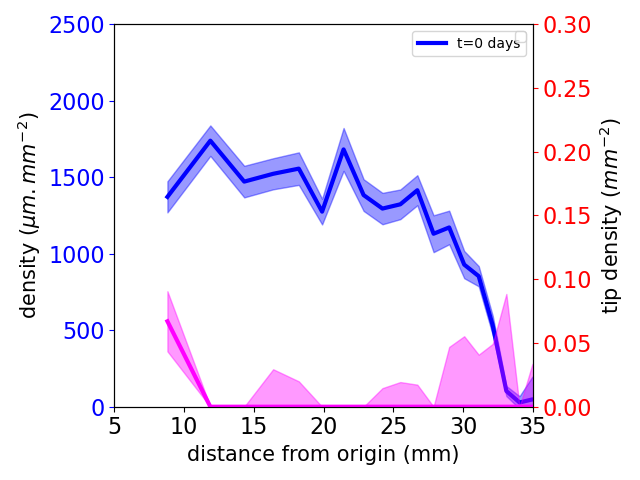

In [16]:
max_indexes = {plate : 20 for plate in plate_select}

plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}

timesteps = range(0,timestep[plate]) 
# timesteps = range(3,4) 

lines = []
for i,t in enumerate(timesteps):
    plt.close("all")
    fig, ax = plt.subplots()
    ax.axis([5,35,0,2500])
    ax.set_xlabel('distance from origin (mm)')
    ax.set_ylabel('density ($\mu m.mm^{-2}$)') 
    ax2=ax.twinx()
    ax2.set_ylim((0,0.30))
    ax2.set_ylabel('tip density ($mm^{-2}$)')
    ax.tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='red')
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-new"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    errvalues = [err(x) for x in xvalues]
    
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i)/len(timesteps)),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    table = table.sort_values('area_sep_comp')
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    # err = 0*ys + 80
    ax.fill_between(xs, ys-err, ys+err,color=cmap((i)/len(timesteps)),alpha = 0.4)
    # draw_error_band(ax, xs, ys,err,color=cmap((len(timesteps)-i)/len(timesteps)),alpha = 0.6)
    #     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]/2000, facecolor=cmap((len(timesteps)-i)/len(timesteps)), edgecolor="white") for j,x in enumerate(xs)]

#     for ellipse in ellipses:
#         ax.add_artist(ellipse)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    # ax.plot(xs,wave(xt,*popt_f),color=cmap((len(timesteps)-i)/len(timesteps)))
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    errvalues = [err(x) for x in xvalues]
    
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    scat2 = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap2((i)/len(timesteps)))
    
    line = {"type" : "data tip density","x" : (np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))),"y" : yvalues,"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1))}
    lines.append(line)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    # ax2.plot(xs,dwave(xt,*popt_f2),color=cmap2((len(timesteps)-i)/len(timesteps)))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    # err = np.std(ys)*abs(ys)/0.10
    err = errvalues
    
    # err = 0*ys + 80
    ax2.fill_between(xs, ys-err, ys+err,color=cmap2((i)/len(timesteps)),alpha = 0.4)
#     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]/0.10, facecolor=cmap2((len(timesteps)-i)/len(timesteps)), edgecolor="white") for j,x in enumerate(xs)]

#     for ellipse in ellipses:
#         ax2.add_artist(ellipse)
    lines_legends.append((scat1, scat2))
    labels.append(f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    

    line = {"type" : "fit tip density","x" : xs,"y" : dwave(xt,*popt_f2),"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1)) }
    lines.append(line)
    right = 0.90
    top = 0.90
    fontsize = 10
    ax.legend()
    ax2.legend()
    plt.tight_layout()
    plt.savefig(f'Video/frame{t}.png')
    # break

In [20]:
timesteps

range(3, 4)

In [21]:
import cv2
import os

# Folder path containing the images
folder_path = "Video/"
timesteps = range(4,timestep[plate]) 

# Get a list of all the image filenames in the folder
image_filenames = [f'frame{t}.png' for t in timesteps]
# Sort the image filenames in ascending order based on timestep (t)
# image_filenames.sort(key=lambda x: int(x[5:-4]))

# Read the first image to get its dimensions
first_image = cv2.imread(os.path.join(folder_path, image_filenames[0]))
height, width, channels = first_image.shape

# Create a VideoWriter object to save the mp4 video
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # codec for mp4 video
video_writer = cv2.VideoWriter('output.mp4', fourcc, 10, (width, height))

# Loop through all the image filenames and write each image to the video
for image_filename in image_filenames:
    image_path = os.path.join(folder_path, image_filename)
    image = cv2.imread(image_path)
    video_writer.write(image)

# Release the VideoWriter object
video_writer.release()

In [6]:
def make_stat(x0,ax):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = 'grey', alpha = 0.01)
        return(a)
    return(statistic)

In [24]:
index

14

In [39]:
index = 12
column = f"ring_density_incr-100_index-{index}-new"
time_plate_info_long.sort_values("datetime")

,ring_density_incr-100_index-15-bootstd,ring_density_incr-100_index-16-bootstd,ring_density_incr-100_index-17-bootstd,ring_density_incr-100_index-18-bootstd,ring_density_incr-100_index-19-bootstd,ring_density_incr-100_index-15-new,ring_density_incr-100_index-16-new,ring_density_incr-100_index-17-new,ring_density_incr-100_index-18-new,ring_density_incr-100_index-19-new,...,ring_active_tips_density_incr-100_index-19-bootstd,time_since_begin_h,folder,unique_id,datetime,PrincePos,root,strain,medium,timestep
0,8.716906,0.0,2.934320,7.577451,10.617553,11.619894,0.000000,0.190568,0.287791,2.242066,...,0.0,0 days 00:00:00,20201123_1253_Plate39,9420201123,2020-11-23 12:53:00,39,'Carrot','A5','001P100N',0
1,9.604535,0.0,2.478607,10.393638,10.656778,12.377419,0.000000,0.190568,0.378672,2.415869,...,0.0,0 days 01:07:00,20201123_1400_Plate39,9420201123,2020-11-23 14:00:00,39,'Carrot','A5','001P100N',1
45,10.191767,0.0,3.104298,7.713483,11.590423,12.242146,0.000000,0.209625,0.333231,2.502771,...,0.0,0 days 02:08:00,20201123_1501_Plate39,9420201123,2020-11-23 15:01:00,39,'Carrot','A5','001P100N',45
56,8.081927,0.0,4.567309,7.275106,10.774739,12.458582,0.000000,0.285852,0.318084,2.468010,...,0.0,0 days 03:08:00,20201123_1601_Plate39,9420201123,2020-11-23 16:01:00,39,'Carrot','A5','001P100N',56
67,9.322861,0.0,4.164661,9.013804,11.406513,12.593854,0.000000,0.247738,0.378672,2.554912,...,0.0,0 days 04:08:00,20201123_1701_Plate39,9420201123,2020-11-23 17:01:00,39,'Carrot','A5','001P100N',67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,NaN,NaN,NaN,NaN,NaN,1134.650816,1047.127208,1233.698577,765.401635,465.845659,...,NaN,7 days 05:16:00,20201130_1809_Plate39,9420201123,2020-11-30 18:09:00,39,'Carrot','A5','001P100N',33
34,NaN,NaN,NaN,NaN,NaN,1162.706298,1057.886649,1276.900324,792.878057,508.549192,...,NaN,7 days 09:16:00,20201130_2209_Plate39,9420201123,2020-11-30 22:09:00,39,'Carrot','A5','001P100N',34
36,NaN,NaN,NaN,NaN,NaN,1145.337330,1043.375897,1238.996366,785.016831,484.407878,...,NaN,7 days 13:16:00,20201201_0209_Plate39,9420201123,2020-12-01 02:09:00,39,'Carrot','A5','001P100N',36
37,NaN,NaN,NaN,NaN,NaN,1173.041104,1113.116172,1211.630813,793.514225,492.924252,...,NaN,7 days 17:16:00,20201201_0609_Plate39,9420201123,2020-12-01 06:09:00,39,'Carrot','A5','001P100N',37


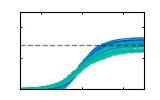

In [66]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
timestep_max = 130
n_resamples=3

maxi = 15
max_area=50
fig,ax = plt.subplots(figsize=(width,height))
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"] == plate].copy()
table_err = table_err.loc[table_err["timestep"] <= timestep_max]
table_err = table_err.set_index("timestep")
table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
table = table.loc[table["timestep"] <= timestep_max]
table = table.set_index("timestep")
# ts = []
# ys = []
# ys2 = []
# Cs = []
# Cserror = []
# t0serror = []
# lambs = []
# indexes = []
# t0s = []
# ds = []
# Cstips2 = []

for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}-new"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    table[column] = table_err[column]
    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    sorted_column = table.sort_values(by=column,ascending=True)
    if len(sorted_column.loc[sorted_column[column] >= 600])>2:
        start = sorted_column.loc[sorted_column[column] >= 600]["time_since_begin"].iloc[2]
        select = table.loc[(table["time_since_begin"]/pd.Timedelta(hours=1)).between(start/pd.Timedelta(hours=1)-50,start/pd.Timedelta(hours=1)+50)]
        select = select.loc[((select["time_since_begin"]>=start)&(select[column]>=600)) | (select["time_since_begin"]<start)&(select[column]<=600)].copy()
        select[f"time_since_begin_{index}"] = (
            select["time_since_begin"] - start
        )/pd.Timedelta(hours=1)
        selection_fit = select
        xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
        popt0, pcov = curve_fit(
            S,
            xis,
            yis,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
        lamb, C, t0 = list(popt0)
        select[f"time_since_begin_{index}"] = select[f"time_since_begin_{index}"] - t0

        ax.scatter(
            select[f"time_since_begin_{index}"],
            select[column],
            alpha=0.5,
            color=cmap2(area / max_area),
        )
        def statistic(x,y):
            try:
                popt0, pcov = curve_fit(
                S,
                x,
                y,
                bounds=([0, 0, -np.inf], 3 * [np.inf]),
                p0=[1, 1, 0],
            )
                return(popt0[1])
            except:
                return(C)
        xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
        data = np.array((xis,yis))
        def statistic(x,y):
            try:
                popt0, pcov = curve_fit(
                S,
                x,
                y,
                bounds=([0, 0, -np.inf], 3 * [np.inf]),
                p0=[1, 1, 0],
            )
                return(popt0[2])
            except:
                return(C)
        xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
        data = np.array((xis,yis))
        x = np.linspace(-50, 50, 100)
        ax.plot(
            x,
            S(x + t0, lamb, C, t0),
            color=cmap2(area / max_area),
            label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
        )
        try:
            popt1, _ = curve_fit(
                dS,
                selection_fit[f"time_since_begin_{index}"],
                selection_fit[column2],
                bounds=([0, 0, -np.inf], 3 * [np.inf]),
                p0=[0.2, 0.5, 0],
            )
        except:
            continue
        lamb, C, t1 = list(popt1)


ax.set_xlim((-30, 30))
# ax2.set_ylim((0, 0.25))
ax.set_ylim((0, 2500))

# ax.set_ylabel("Network density \n ($\mu m.mm^{-2}$)")
# ax.set_xlabel("shifted time, $t-t_n$ ($hours$)")
# ax2.set_ylabel("Active tips density ($mm^{-2}$)")
ax.tick_params(axis="y", colors="blue")
# ax2.tick_params(axis="y", colors="red")
# ax.set_yticks([])  # Remove xticks
# ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.hlines(Cmean,-30,30,color='black',linestyle='--',alpha = 0.5)


# ax2.set_yticks([])  # Remove xticks
# ax2.set_ylabel('') 
# ax2.legend(fontsize=8)
# plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2C.svg'))
# plt.savefig(os.path.join(path_figure,'Figure2C1.eps'))
plt.savefig(os.path.join(path_figure,'Figure2C1.pdf'),transparent=True, bbox_inches='tight')


In [53]:
np.mean(Cs)

1345.4259268664382

2023-04-16 14:30:26,260-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


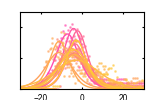

In [58]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
timestep_max = 130
n_resamples=3

maxi = 15
max_area=50
fig,ax2 = plt.subplots(figsize=(width,height))
table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
table = table.loc[table["timestep"] <= timestep_max]
table = table.set_index("timestep")
ts = []
ys = []
ys2 = []
Cs = []
Cserror = []
t0serror = []
lambs = []
indexes = []
t0s = []
ds = []
Cstips2 = []

for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"

    start = np.min(
        table.loc[table[column] >= 400]["time_since_begin"]
    )
    table[f"time_since_begin_{index}"] = (
        table["time_since_begin"] - start
    )/pd.Timedelta(hours = 1)

    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = table
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]

    selection_fit = table

    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    table[f"time_since_begin_{index}"] = table[f"time_since_begin_{index}"] - t0

    # ax.scatter(
    #     table[f"time_since_begin_{index}"],
    #     table[column],
    #     alpha=0.5,
    #     color=cmap2(area / max_area),
    # )
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[1])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[2])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    t0s.append(t0+start/pd.Timedelta(hours=1))
    
    Cs.append(C)
    lambs.append(lamb)
    indexes.append(index)
    ds.append(int(area / np.sqrt((np.pi / 2))))
    x = np.linspace(-50, 50, 100)
    # ax.plot(
    #     x,
    #     S(x + t0, lamb, C, t0),
    #     color=cmap2(area / max_area),
    #     label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    # )
    try:
        popt1, _ = curve_fit(
            dS,
            selection_fit[f"time_since_begin_{index}"],
            selection_fit[column2],
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[0.2, 0.5, 0],
        )
    except:
        continue
    lamb, C, t1 = list(popt1)
    Cstips2.append(C)
    ax2.scatter(
        table[f"time_since_begin_{index}"],
        table[column2],
        alpha=0.5,
        color=cmap1(area / max_area),
    )
    ax2.plot(
        x,
        dS(x, lamb, C, t1),
        color=cmap1(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    ts += table[f"time_since_begin_{index}"].to_list()
    ys += table[column].to_list()
    ys2 += table[column2].astype(float).to_list()
df = pd.DataFrame(
    (np.array((ts, ys, ys2))).transpose(), columns=("ts", "ys", "ys2")
)
factor = 4
df["ts_round"] = (df["ts"] / factor).astype(int) * factor
meancurve = df.groupby("ts_round")["ys"].mean()
# ax.plot(meancurve.index, meancurve, label="mean", color="black")
meancurve2 = df.groupby("ts_round")["ys2"].mean()
# ax2.plot(meancurve.index-t1, meancurve2, label=plate, color = 'black')
ax2.set_xlim((-30, 30))
ax2.set_ylim((0, 0.25))
# ax.set_ylim((0, 2500))

# ax.set_ylabel("Network density \n ($\mu m.mm^{-2}$)")
ax2.set_xlabel("shifted time, $t-t_n$ ($hours$)")
# ax2.set_ylabel("Active tips density ($mm^{-2}$)")
# ax.tick_params(axis="y", colors="blue")
# ax2.tick_params(axis="y", colors="red")
# ax.set_yticks([])  # Remove xticks
# ax.set_ylabel('')
ax2.set_yticklabels([])


# ax2.set_yticks([])  # Remove xticks
# ax2.set_ylabel('') 
# ax2.legend(fontsize=8)
# plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2C.svg'))
# plt.savefig(os.path.join(path_figure,'Figure2C1.eps'))
plt.savefig(os.path.join(path_figure,'Figure2C2.pdf'),transparent=True, bbox_inches='tight')


In [ ]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
fig,ax = plt.subplots()
timestep_max = 100
n_resamples=1000

maxi = 13
max_area=50
ax2 = ax.twinx()
table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
table = table.loc[table["timestep"] <= timestep_max]
table = table.set_index("timestep")
ts = []
ys = []
ys2 = []
Cs = []
Cserror = []
t0serror = []
lambs = []
indexes = []
t0s = []
ds = []
for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"

    start = np.min(
        table.loc[table[column] >= 400]["time_since_begin"]
    )
    table[f"time_since_begin_{index}"] = (
        table["time_since_begin"] - start
    )/pd.Timedelta(hours = 1)

    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = table
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]

    selection_fit = table

    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    table[f"time_since_begin_{index}"] = table[f"time_since_begin_{index}"] - t0

    ax.scatter(
        table[f"time_since_begin_{index}"],
        table[column],
        alpha=0.5,
        color=cmap2(area / max_area),
    )
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[1])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    std = scipy.stats.bootstrap(data,statistic,
                        vectorized = False,
                        method="basic",
                        n_resamples = n_resamples,
                        paired= True).standard_error
    Cserror.append(std)
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[2])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    std = scipy.stats.bootstrap(data,statistic,
                        vectorized = False,
                        method="basic",
                        n_resamples = n_resamples,
                        paired= True).standard_error
    t0serror.append(std)
    t0s.append(t0+start/pd.Timedelta(hours=1))
    
    Cs.append(C)
    lambs.append(lamb)
    indexes.append(index)
    ds.append(int(area / np.sqrt((np.pi / 2))))
    x = np.linspace(-50, 50, 100)
    ax.plot(
        x,
        S(x + t0, lamb, C, t0),
        color=cmap2(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    try:
        popt1, _ = curve_fit(
            dS,
            selection_fit[f"time_since_begin_{index}"],
            selection_fit[column2],
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[0.2, 0.5, 0],
        )
    except:
        continue
    lamb, C, t1 = list(popt1)
    ax2.scatter(
        table[f"time_since_begin_{index}"]-t1,
        table[column2],
        alpha=0.5,
        color=cmap1(area / max_area),
    )
    ax2.plot(
        x,
        dS(x +t1, lamb, C, t1),
        color=cmap1(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    ts += table[f"time_since_begin_{index}"].to_list()
    ys += table[column].to_list()
    ys2 += table[column2].astype(float).to_list()
df = pd.DataFrame(
    (np.array((ts, ys, ys2))).transpose(), columns=("ts", "ys", "ys2")
)
factor = 4
df["ts_round"] = (df["ts"] / factor).astype(int) * factor
meancurve = df.groupby("ts_round")["ys"].mean()
# ax.plot(meancurve.index, meancurve, label="mean", color="black")
meancurve2 = df.groupby("ts_round")["ys2"].mean()
# ax2.plot(meancurve.index-t1, meancurve2, label=plate, color = 'black')
ax.set_xlim((-30, 30))
ax2.set_ylim((0, 0.25))
ax.set_ylim((0, 2500))

ax.set_ylabel("Network density ($\mu m.mm^{-2}$)")
ax.set_xlabel("Shifted time ($h$)")
ax2.set_ylabel("Active tips density ($mm^{-2}$)")
ax.tick_params(axis="y", colors="blue")
ax2.tick_params(axis="y", colors="red")
# ax.legend(fontsize=8)
plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2C.svg'))
plt.savefig(os.path.join(path_figure,'Figure2C.eps'))


c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:37: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))


c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:55: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:55: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:55: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:55: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:55: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))
c:\users\coren\documents\phd\code\amftrack\amftrack\pip

2023-04-16 14:38:47,458-[WARNING]- matplotlib.backends.backend_ps:296 -> The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-04-16 14:38:47,896-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped
2023-04-16 14:38:49,344-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


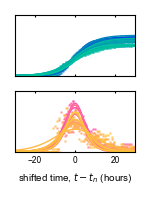

In [59]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
timestep_max = 130
n_resamples=1000

maxi = 15
max_area=50
f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(1.5,2))
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"] == plate].copy()
table_err = table_err.loc[table_err["timestep"] <= timestep_max]
table_err = table_err.set_index("timestep")
table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
table = table.loc[table["timestep"] <= timestep_max]
table = table.set_index("timestep")
ts = []
ys = []
ys2 = []
Cs = []
Cserror = []
t0serror = []
lambs = []
indexes = []
t0s = []
ds = []
Cstips2 = []

for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}-new"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    table[column] = table_err[column]
    sorted_column = table.sort_values(by=column,ascending=True)
    start = sorted_column.loc[sorted_column[column] >= 600]["time_since_begin"].iloc[2]
    select = table.loc[(table["time_since_begin"]/pd.Timedelta(hours=1)).between(start/pd.Timedelta(hours=1)-50,start/pd.Timedelta(hours=1)+50)]
    select = select.loc[((select["time_since_begin"]>=start)&(select[column]>=600)) | (select["time_since_begin"]<start)&(select[column]<=600)].copy()
    select[f"time_since_begin_{index}"] = (
        select["time_since_begin"] - start
    )/pd.Timedelta(hours = 1)
    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = select
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    select[f"time_since_begin_{index}"] = select[f"time_since_begin_{index}"] - t0

    ax.scatter(
        select[f"time_since_begin_{index}"],
        select[column],
        alpha=0.5,
        color=cmap2(area / max_area),
    )
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[1])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    std = scipy.stats.bootstrap(data,statistic,
                        vectorized = False,
                        method="basic",
                        n_resamples = n_resamples,
                        paired= True).standard_error
    Cserror.append(std)
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[2])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    std = scipy.stats.bootstrap(data,statistic,
                        vectorized = False,
                        method="basic",
                        n_resamples = n_resamples,
                        paired= True).standard_error
    t0serror.append(std)
    t0s.append(t0+start/pd.Timedelta(hours=1))
    
    Cs.append(C)
    lambs.append(lamb)
    indexes.append(index)
    ds.append(int(area / np.sqrt((np.pi / 2))))
    x = np.linspace(-50, 50, 100)
    ax.plot(
        x,
        S(x + t0, lamb, C, t0),
        color=cmap2(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    try:
        popt1, _ = curve_fit(
            dS,
            selection_fit[f"time_since_begin_{index}"],
            selection_fit[column2],
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[0.2, 0.5, 0],
        )
    except:
        continue
    lamb, C, t1 = list(popt1)
    Cstips2.append(C)
    ax2.scatter(
        select[f"time_since_begin_{index}"]-t1,
        select[column2],
        alpha=0.5,
        color=cmap1(area / max_area),
    )
    ax2.plot(
        x,
        dS(x +t1, lamb, C, t1),
        color=cmap1(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    
ax.set_xlim((-30, 30))
ax2.set_ylim((0, 0.25))
ax.set_ylim((0, 2500))

# ax.set_ylabel("Network density \n ($\mu m.mm^{-2}$)")
ax2.set_xlabel("shifted time, $t-t_n$ (hours)")
# ax2.set_ylabel("Active tips density ($mm^{-2}$)")
ax.tick_params(axis="y", colors="blue")
ax2.tick_params(axis="y", colors="red")
ax.set_yticks([])  # Remove xticks
ax.set_ylabel('')
ax2.set_yticks([])  # Remove xticks
ax2.set_ylabel('') 
# ax2.legend(fontsize=8)
plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2C.svg'))
plt.savefig(os.path.join(path_figure,'Figure2C.eps'))
plt.savefig(os.path.join(path_figure,'Figure2C.pdf'),transparent=True)


In [7]:
popt1[1]

0.4954009136788319

C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\coren\anaconda3\envs\amftrack\lib\site-pac

ValueError: Residuals are not finite in the initial point.

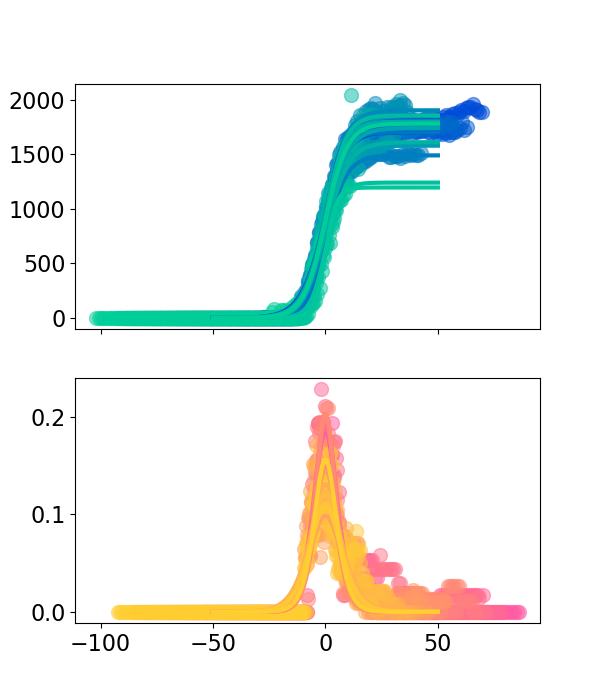

In [16]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
timestep_max = 100
n_resamples=1

maxi = 13
max_area=50
f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(6,7))
table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
table = table.loc[table["timestep"] <= timestep_max]
table = table.set_index("timestep")
ts = []
ys = []
ys2 = []
Cs = []
Cserror = []
t0serror = []
lambs = []
indexes = []
t0s = []
ds = []
Cstips = []
for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-2_index-{index}"

    start = np.min(
        table.loc[table[column] >= 400]["time_since_begin"]
    )
    table[f"time_since_begin_{index}"] = (
        table["time_since_begin"] - start
    )/pd.Timedelta(hours = 1)

    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = table
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]

    selection_fit = table

    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    table[f"time_since_begin_{index}"] = table[f"time_since_begin_{index}"] - t0

    ax.scatter(
        table[f"time_since_begin_{index}"],
        table[column],
        alpha=0.5,
        color=cmap2(area / max_area),
    )
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[1])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    std = scipy.stats.bootstrap(data,statistic,
                        vectorized = False,
                        method="basic",
                        n_resamples = n_resamples,
                        paired= True).standard_error
    Cserror.append(std)
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[2])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    std = scipy.stats.bootstrap(data,statistic,
                        vectorized = False,
                        method="basic",
                        n_resamples = n_resamples,
                        paired= True).standard_error
    t0serror.append(std)
    t0s.append(t0+start/pd.Timedelta(hours=1))
    
    Cs.append(C)
    lambs.append(lamb)
    indexes.append(index)
    ds.append(int(area / np.sqrt((np.pi / 2))))
    x = np.linspace(-50, 50, 100)
    ax.plot(
        x,
        S(x + t0, lamb, C, t0),
        color=cmap2(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    try:
        popt1, _ = curve_fit(
            dS,
            selection_fit[f"time_since_begin_{index}"],
            selection_fit[column2],
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[0.2, 0.5, 0],
        )
    except:
        continue
    lamb, C, t1 = list(popt1)
    Cstips.append(C)
    ax2.scatter(
        table[f"time_since_begin_{index}"]-t1,
        table[column2],
        alpha=0.5,
        color=cmap1(area / max_area),
    )
    ax2.plot(
        x,
        dS(x +t1, lamb, C, t1),
        color=cmap1(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    ts += table[f"time_since_begin_{index}"].to_list()
    ys += table[column].to_list()
    ys2 += table[column2].astype(float).to_list()
df = pd.DataFrame(
    (np.array((ts, ys, ys2))).transpose(), columns=("ts", "ys", "ys2")
)
factor = 4
df["ts_round"] = (df["ts"] / factor).astype(int) * factor
meancurve = df.groupby("ts_round")["ys"].mean()
# ax.plot(meancurve.index, meancurve, label="mean", color="black")
meancurve2 = df.groupby("ts_round")["ys2"].mean()
# ax2.plot(meancurve.index-t1, meancurve2, label=plate, color = 'black')
ax.set_xlim((-30, 30))
ax2.set_ylim((0, 0.25))
ax.set_ylim((0, 2500))

ax.set_ylabel("Network density ($\mu m.mm^{-2}$)")
ax2.set_xlabel("Shifted time ($h$)")
ax2.set_ylabel("Active tips density ($mm^{-2}$)")
ax.tick_params(axis="y", colors="blue")
ax2.tick_params(axis="y", colors="red")
# ax2.legend(fontsize=8)
plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2C.svg'))
# plt.savefig(os.path.join(path_figure,'Figure2C.eps'))


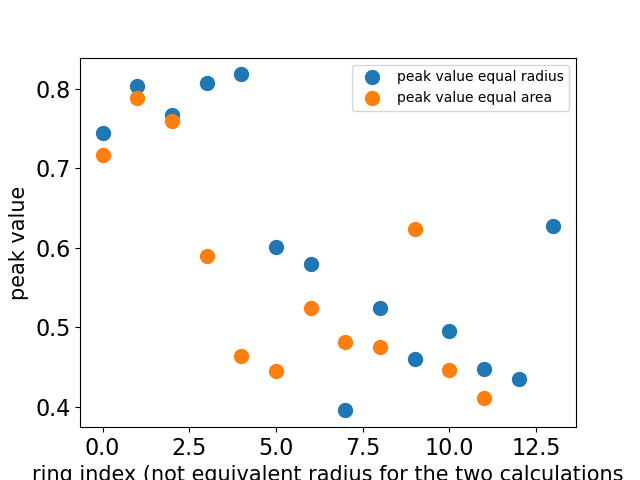

In [23]:
fig, ax = plt.subplots()
ax.scatter(range(len(Cstips)),Cstips,label="peak value equal radius")
ax.scatter(range(len(Cstips2)),Cstips2,label="peak value equal area")
ax.set_xlabel("ring index (not equivalent radius for the two calculations")
ax.set_ylabel("peak value")

ax.legend()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

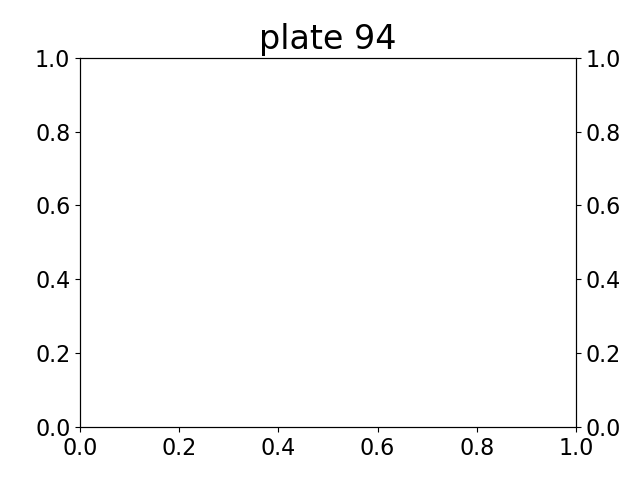

In [63]:
fig,ax = plt.subplots()
maxis = {plate :13 for plate in plate_select}

Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info,timestep[plate],ax,maxi =maxis[plate])
ax.set_title('')
ax.set_ylim(0,2500)
# bbox = dict(facecolor='white', alpha = 0.7,edgecolor="None")

# axins2 = inset_axes(ax, width="30%", height="30%", loc=1,borderpad = .5)
# x0 = np.linspace(np.min(ds),np.max(ds),10)
# statistic = make_stat(x0,axins2)
# data = np.array((ds,Cs))
# n_resamples=1000
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error
# X = sm.add_constant(ds, prepend=False)
# model = sm.OLS(Cs,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# axins2.plot(ds,np.array(ds)*a+b,label = f"{round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
# axins2.scatter(ds,Cs,s=2,label="data")
# axins2.set_ylim(0,2000)
# axins2.set_xlabel('distance from origin (mm)',size = 5,bbox=bbox)
# axins2.set_ylabel('saturation density($\mu m.mm^{-2}$)',size = 5,bbox=bbox)
# axins2.tick_params(labelsize = 5)
# axins2.legend(fontsize = 6)
# axins3 = inset_axes(ax, width="30%", height="30%", loc=4,borderpad = 0.5)
# x0 = np.linspace(np.min(t0s),np.max(t0s),10)
# statistic = make_stat(x0,axins3)
# data = np.array((t0s,ds))
# n_resamples=1000
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error
# axins3.scatter(t0s,ds,label = "data",s=2)
# X = sm.add_constant(t0s, prepend=False)
# model = sm.OLS(ds,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# axins3.plot(t0s,np.array(t0s)*a+b,label = f"{int(1000*a)}$\pm$ {int(1000*std)}$\mu m.h^{-1}$",color="black")
# axins3.xaxis.tick_top()
# axins3.xaxis.set_label_position('top') 
# axins3.legend(fontsize = 6 )
# axins3.set_ylabel('distance from center (mm)',size = 5,bbox=bbox)
# axins3.set_xlabel('time of wave crossing (hours)',size = 5,bbox=bbox)
# axins3.tick_params(labelsize = 5)
# ax.legend('',frameon = False)
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure2"
plt.savefig(os.path.join(path_figure,'Figure2B.svg'))

2023-04-16 14:41:58,383-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


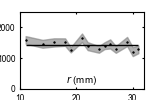

In [70]:
fig, ax = plt.subplots(figsize=(width,height))
ax.set_xlabel('$r$ (mm)')
ax.set_ylabel('saturation density \n ($\mu m.mm^{-2}$)',labelpad=1)
ax.xaxis.set_label_coords(0.5, 0.20)
# plt.tight_layout()
x0 = np.linspace(np.min(ds),np.max(ds),10)
err = np.array(Cserror)
ax.fill_between(ds, Cs-err, Cs+err,color="grey",alpha = 0.6)
X = sm.add_constant(ds, prepend=False)
model = sm.OLS(Cs,X)
res = model.fit()
a,b = res.params[0],res.params[1]
# ax.plot(ds,np.array(ds)*a+b,label = f"linear fit : coef = {round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
# plt.legend()
ax.scatter(ds,Cs,marker="+",color="black")
ax.hlines(Cmean,min(ds),max(ds),color='black')

ax.set_ylim(0,2500)
# plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure2D.svg'))
# plt.savefig(os.path.join(path_figure,'Figure2E.eps'))
plt.savefig(os.path.join(path_figure,'Figure2E.pdf'),transparent=True, bbox_inches='tight')



In [63]:
np.mean(Cs)

1421.6414597133864

In [41]:
plates = [plate]
analysis_folders = analysis_folders.loc[analysis_folders['Plate'].isin(plates)]
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)

In [42]:
plate = 94
plate_id = '94_20201123'

2023-04-14 10:23:02,776-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


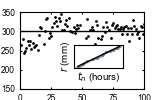

In [43]:
fig, axins2 = plt.subplots(figsize=(width,height))
ax = inset_axes(axins2, width="40%", height="30%", loc=4, borderpad = 1.5)

ax.scatter(t0s,ds,label = "data",s = 1)
err = np.array(t0serror)/100
    # err = 0*ys + 80
ax.fill_betweenx(ds, t0s-err, t0s+err,color="grey",alpha = 0.6)
X = sm.add_constant(t0s, prepend=False)
model = sm.OLS(ds,X)
res = model.fit()
a,b = res.params[0],res.params[1]
ax.plot(t0s,np.array(t0s)*a+b,label = f"linear fit : speed = {int(1000*a)}$\pm$ {int(1000*std)}$\mu m.h^{-1}$",color='black')
# ax.legend()
ax.set_ylabel('$r$ (mm)')
ax.set_xlabel('$t_n$ (hours)')
# plt.tight_layout()
hull_speeds = []
hull_time = []
time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]

data,dy,select_movements = get_average_time_data(plate,time_hypha_info,2)
hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
if len(hyphae_hull)>0:
    label = 'hull pusher'
    for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        select = select.loc[select['speed'].between(200,350)]
        if len(select)>0:
            axins2.scatter((select['time_since_begin_h']/3.6e6).iloc[0],np.mean(select["speed"]),color='black')
            # axins2.errorbar(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
            label = None
            hull_speeds.append(np.mean(select["speed"]))
            hull_time.append((select['time_since_begin_h']/3.6e6).iloc[0])

        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        # break
        # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
    # ax.plot(data.index/pd.Timedelta(hours = 1),data)
    # axins2.errorbar(data.index/pd.Timedelta(hours = 1),data, yerr=dy,label='average')
    axins2.set_xlim(0,150)
    axins2.set_ylim(150,350)

# axins2.legend()
axins2.set_xlabel('time since crossing (hours)')
axins2.set_ylabel('speed ($\mu m.h^{-1}$)')
ax.set_yticks([])  
ax.set_xticks([])  

ax.tick_params()

axins2.set_xlim(0,100)
# plt.tight_layout()
axins2.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
        color="black",
        label= f'mean hull pusher speed {int(np.mean(hull_speeds))}$\pm${int(2*np.std(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')


ax.xaxis.labelpad = 1
ax.yaxis.labelpad = 1
# plt.savefig(os.path.join(path_figure,'Figure2D.svg'))
# plt.savefig(os.path.join(path_figure,'Figure2D.eps'))
plt.savefig(os.path.join(path_figure,'Figure2D.pdf'),transparent=True, bbox_inches='tight')

In [26]:
select['time_since_begin_h']/1e9

133356    1.1394
133357    1.1394
133358    1.1394
133359    1.1394
133360    1.1394
           ...  
135710    1.1394
135711    1.1394
135712    1.1394
135713    1.1394
135714    1.1394
Name: time_since_begin_h, Length: 2359, dtype: float64

C:\Users\coren\AppData\Local\Temp\ipykernel_20636\2906465994.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


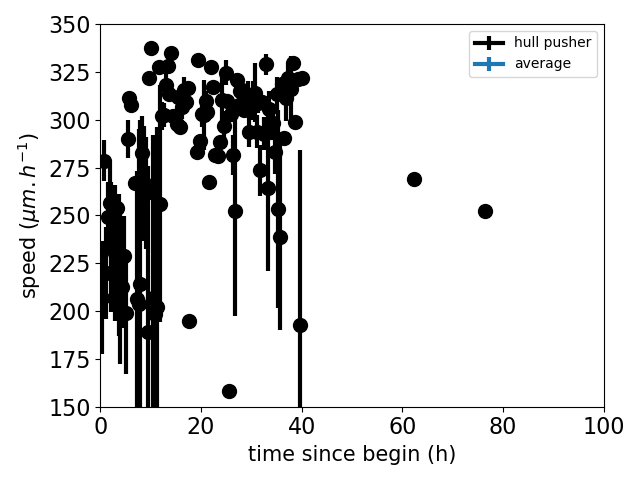

In [31]:
hull_speeds = []
hull_time = []
time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]

fig,ax = plt.subplots()
data,dy,select_movements = get_average_time_data(plate,time_hypha_info,2)
hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
if len(hyphae_hull)>0:
    label = 'hull pusher'
    for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        select = select.loc[select['speed'].between(50,350)]
        if len(select)>0:
            ax.scatter(select['time_since_begin_h'].iloc[0]/1e7,np.mean(select["speed"]),color='black')
            ax.errorbar(select['time_since_begin_h'].iloc[0]/1e7,np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
            label = None
            hull_speeds.append(np.mean(select["speed"]))
            hull_time.append(select['time_since_begin_h'].iloc[0])

        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
    # ax.plot(data.index/pd.Timedelta(hours = 1),data)
    ax.errorbar(data.index,data, yerr=dy,label='average')
    ax.set_xlim(0,150)
    ax.set_ylim(150,350)

# ax.set_title(f'{plate}')
ax.set_xlabel('time since begin (h)')
ax.set_ylabel('speed ($\mu m.h^{-1}$)')
    # break
ax.set_xlim(0,100)
plt.tight_layout()
# ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
#         color="black",
#         label= f'mean hull pusher speed {int(np.mean(hull_speeds))}$\pm${int(2*np.std(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
ax.legend()
# plt.savefig(f'Figure/Figure1Csubset.svg')
